<a href="https://colab.research.google.com/github/hakdj/mlearning/blob/master/0925_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 도구 모음

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 64.0 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import nltk  # natural language toolkit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import konlpy
from konlpy.tag import Okt
okt = Okt() # 형태소 추출
from konlpy.tag import Twitter # 한글 형태소 추출

from collections import Counter # count 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 파일 가져오기

In [3]:
df=pd.read_csv('./youtubecomment.csv',encoding='cp949')

In [4]:
df.isnull().sum()

title      0
video      0
comment    3
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9182 entries, 0 to 9181
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9182 non-null   object
 1   video    9182 non-null   object
 2   comment  9179 non-null   object
dtypes: object(3)
memory usage: 215.3+ KB


In [6]:
df

,title,video,comment
0,콩,eu7HhcuRsL4,대부분이 레시피만 올리는데 요리과정도 올려주시니 더 이해하고 따라하기가 쉬울것 같아...
1,콩,eu7HhcuRsL4,맛나겠네요 ㅎㅎ
2,콩,eu7HhcuRsL4,믹서기를 사야겄네..
3,콩,eu7HhcuRsL4,골목막걸리란게 있었네요ㅋㅋ 콩전이랑 캬~~ㅋ 뉴욕사는 딸에게 공유했답니다~
4,콩,eu7HhcuRsL4,나중에 해줘야디
...,...,...,...
9177,열무,8PEOg1YFqUU,꼭 해봐야겠네요 맛있게 잘 될것같아요
9178,열무,8PEOg1YFqUU,배즙 말고 다른 재료는 어떤게 있을까요? 배가 많이 비싸요
9179,열무,8PEOg1YFqUU,좋아요 꾹 입니다
9180,열무,8PEOg1YFqUU,"수박을 열무랑 함께하면 무슨 맛일까..? 궁금해서 저도 열무,얼갈이 사러 갑니다.ㅎ..."


In [7]:
df2=df.dropna(how='any')

In [8]:
df2=df2.reset_index()

In [9]:
df2

,index,title,video,comment
0,0,콩,eu7HhcuRsL4,대부분이 레시피만 올리는데 요리과정도 올려주시니 더 이해하고 따라하기가 쉬울것 같아...
1,1,콩,eu7HhcuRsL4,맛나겠네요 ㅎㅎ
2,2,콩,eu7HhcuRsL4,믹서기를 사야겄네..
3,3,콩,eu7HhcuRsL4,골목막걸리란게 있었네요ㅋㅋ 콩전이랑 캬~~ㅋ 뉴욕사는 딸에게 공유했답니다~
4,4,콩,eu7HhcuRsL4,나중에 해줘야디
...,...,...,...,...
9174,9177,열무,8PEOg1YFqUU,꼭 해봐야겠네요 맛있게 잘 될것같아요
9175,9178,열무,8PEOg1YFqUU,배즙 말고 다른 재료는 어떤게 있을까요? 배가 많이 비싸요
9176,9179,열무,8PEOg1YFqUU,좋아요 꾹 입니다
9177,9180,열무,8PEOg1YFqUU,"수박을 열무랑 함께하면 무슨 맛일까..? 궁금해서 저도 열무,얼갈이 사러 갑니다.ㅎ..."


### 원하는 농수산물 선택해서 list에 담기

In [124]:
lists=[]
ans=input()
for i in range(0,len(df2)):
  if df2['title'][i]==ans:
    lists.append(df2['comment'][i])
len(lists)


콩


2124

In [125]:
# 담긴 내용 확인용
#lists

### 이모티콘 제거
### 코멘트 df 생성 및 저장

In [12]:
import re

In [13]:
#이모티콘 제거
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
han = re.compile(r'[^ ㄱ-ㅣ 가-힣ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')

def apply_regular_expression(text):
    hans = re.compile(r'[^ ㄱ-ㅣ 가-힣ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]') # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hans.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result


In [14]:
#코멘트 df생성 및 저장
comment_result = []
for i in range(0,len(lists)):
  tokens = re.sub(emoji_pattern,"", lists[i])
  tokens = re.sub(han,"",tokens)
  comment_result.append(tokens)

comment_result = pd.DataFrame(comment_result, columns=["comment"])
#comment_result
comment_result.to_csv(r"./"+f"{ans}.csv",index=False, encoding='CP949')
type(comment_result)

pandas.core.frame.DataFrame

# 분석

### 명사 전처리 및 빈도 출력

In [15]:
twitter = Twitter() 
morphs = [] 
for sentence in lists: 
    morphs.append(twitter.pos(sentence)) 

In [16]:
#확인용
morphs

[[('저희', 'Noun'),
  ('어머니', 'Noun'),
  ('해드렸는데', 'Verb'),
  ('맛있다', 'Adjective'),
  ('그러시더라구요', 'Adjective'),
  ('ㅎㅎ', 'KoreanParticle')],
 [('Mhm', 'Alpha'),
  ('i', 'Alpha'),
  ('wonder', 'Alpha'),
  ('if', 'Alpha'),
  ('i', 'Alpha'),
  ('can', 'Alpha'),
  ('use', 'Alpha'),
  ('green', 'Alpha'),
  ('mustard', 'Alpha'),
  ('instead', 'Alpha'),
  ('of', 'Alpha'),
  ('young', 'Alpha'),
  ('radishes', 'Alpha'),
  ('.', 'Punctuation'),
  ('It', 'Alpha'),
  ('’', 'Punctuation'),
  ('s', 'Alpha'),
  ('not', 'Alpha'),
  ('available', 'Alpha'),
  ('in', 'Alpha'),
  ('my', 'Alpha'),
  ('area', 'Alpha')],
 [('백', 'Modifier'),
  ('선생님', 'Noun'),
  ('!', 'Punctuation'),
  ('오늘', 'Noun'),
  ('도', 'Josa'),
  ('덕분', 'Noun'),
  ('에', 'Josa'),
  ('맛있는', 'Adjective'),
  ('점심', 'Noun'),
  ('먹었어요', 'Verb'),
  ('.', 'Punctuation'),
  ('친정', 'Noun'),
  ('텃밭', 'Noun'),
  ('에서', 'Josa'),
  ('뽑아', 'Verb'),
  ('온', 'Noun'),
  ('열무', 'Noun'),
  ('가', 'Josa'),
  ('너무', 'Adverb'),
  ('많아서', 'Adjective'),
  ('어떻게'

In [17]:
noun_adj_adv_list=[] 
for sentence in morphs : 
    for word, tag in sentence : 
        if tag in ['Alpha'] and ("또" not in word)and ("등" not in word)and ("앞" not in word)and ("생" not in word)and ("를" not in word)and ("여기" not in word)and ("다른" not in word)and ("예" not in word)and ("은" not in word)and ("위해" not in word)and ("다음" not in word)and ("대한" not in word)and ("아주" not in word)and ("그" not in word)and ("도움" not in word)and ("약" not in word)and ("때문" not in word)and ("여러" not in word) and ("더" not in word) and ("이" not in word) and ("의" not in word) and ("및" not in word) and ("것" not in word) and ("내" not in word)and ("나" not in word)and ("수"not in word) and("게"not in word)and("말"not in word) : 
            noun_adj_adv_list.append(word) 
        if tag in ['Noun'] and ("또" not in word)and ("등" not in word)and ("앞" not in word)and ("생" not in word)and ("를" not in word)and ("여기" not in word)and ("다른" not in word)and ("예" not in word)and ("은" not in word)and ("위해" not in word)and ("다음" not in word)and ("대한" not in word)and ("아주" not in word)and ("그" not in word)and ("도움" not in word)and ("약" not in word)and ("때문" not in word)and ("여러" not in word) and ("더" not in word) and ("이" not in word) and ("의" not in word) and ("및" not in word) and ("것" not in word) and ("내" not in word)and ("나" not in word)and ("수"not in word) and("게"not in word)and("말"not in word) : 
            noun_adj_adv_list.append(word) 
print(noun_adj_adv_list)

['저희', '어머니', 'Mhm', 'i', 'wonder', 'if', 'i', 'can', 'use', 'green', 'mustard', 'instead', 'of', 'young', 'radishes', 'It', 's', 'not', 'available', 'in', 'my', 'area', '오늘', '덕분', '점심', '친정', '텃밭', '온', '열무', '고', '제대로', '항상', '왜', '노랑', '색', '열무', '데', '꼭', '고소', '단점', '국물', '읍', '뻑뻑', '역시', '백종원', '레시피', '당장', '해먹', '저', '정보', '좀', '빛', '자', '알', '판끼', '열무', '항상', '김치', '해', '오늘', '밥', '해', '너', '무', '역시', '굿', '굿굿굿', '사라', '거', '형님', '된장', '쥬', '된장', '어유', '됫', '기', '거', '잡솨', '형', '만능', '사라', '거', '돠', '저', '요리', '요리', '저', '요리', '계속', '요리', '해', '응원', '열무', '열무', '해먹', '김', '열무', '양념', '간장', '별미', '오늘', '열무', '대신', '가지', '존맛', '료', '준비', '도중', '식용유', '올리브유', '걱정', '된장', '고추장', '향', '올리브', '향', '다행', '고온', '엑스트라', '버진', '타', '가지', '올리브유', '궁합', '인분', '정도', '쟁', '거', '진짜', '배추', '거', '양배추', '쌈', '진짜', '존맛', '양배추', '통', '혼자', '돼지고기', '시금치', '청량고추', '밥', '해먹', '시금치', '열무', '해도', '미국', '무심', '거', '맛', '설', '막', '얼', '배추', '식감', '삭', '열무', '버전', '보리밥', '맛', '청양고추', '꼭', '풋', '고추', '오리

In [18]:
count = Counter(noun_adj_adv_list)
words = dict(count.most_common())
print(words)

{'열무': 42, '거': 20, '맛': 20, '된장': 14, '해': 13, '진짜': 13, '요리': 12, '열무김치': 12, '레시피': 10, '밥': 9, '융': 9, '오늘': 8, '백종원': 8, '해먹': 8, '항상': 7, '저': 7, '좀': 7, '보고': 7, '요': 6, '집': 6, '때': 6, '최고': 6, '왜': 5, '꼭': 5, '향': 5, '해도': 5, '삭': 5, '방송': 5, '역시': 4, '유': 4, '영상': 4, '여름': 4, '쌤': 4, '음식': 4, '홍보': 4, '덕분': 3, '온': 3, '국물': 3, '알': 3, '김치': 3, '가지': 3, '존맛': 3, '정도': 3, '쌈': 3, '돼지고기': 3, '시금치': 3, '얼': 3, '방법': 3, '애': 3, '처음': 3, '완전': 3, '감사': 3, '주부': 3, '입맛': 3, '소리': 3, '글': 3, '어디': 3, 'gt': 3, 'lt': 3, '난': 3, '냉면': 3, '활용': 3, '줄': 3, '대표': 3, '마음': 3, '사진': 3, '사용': 3, '저희': 2, 'i': 2, 'use': 2, 'of': 2, 'in': 2, 'my': 2, '정보': 2, '무': 2, '사라': 2, '형님': 2, '양념': 2, '준비': 2, '올리브유': 2, '고추장': 2, '배추': 2, '양배추': 2, '통': 2, '식감': 2, '보리밥': 2, '간': 2, 'g': 2, '다시': 2, '뿌리': 2, '고기': 2, '냄새': 2, '사람': 2, '개인': 2, '강추': 2, '조합': 2, '진심': 2, '용': 2, '하루': 2, '잎': 2, '로': 2, '점점': 2, '대박': 2, '참고': 2, '장사': 2, '식당': 2, '출연': 2, '개맛': 2, '메뉴': 2, '로만': 2, '정상': 2, '장': 2, '특

### 시각화

In [19]:
from wordcloud import WordCloud # 텍스트 시각화
import matplotlib.pyplot as plt # 시각화 패키지
import matplotlib 
from IPython.display import set_matplotlib_formats

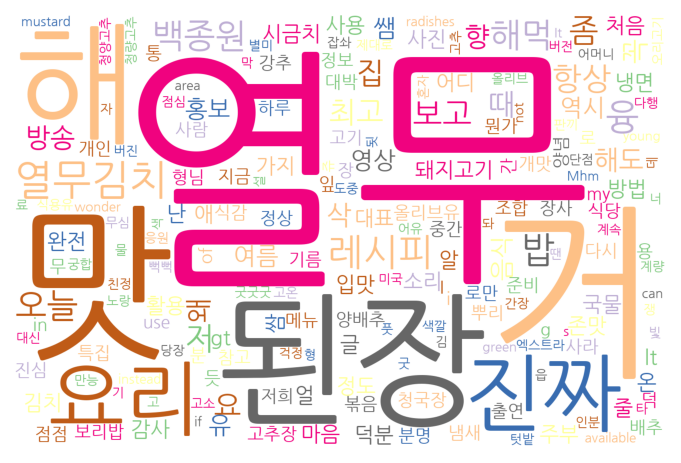

In [23]:
#word cloud show
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)

wordcloud = WordCloud(font_path = '/content/Nanum.TTF', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words) 

plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

### 그래프

In [24]:
import matplotlib.pylab as plt2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = "/content/NanumSquareL.ttf"
fontprop = fm.FontProperties(fname=path, size=20) # 글자 크기 조정

In [25]:
def get_noun(comment_txt):
    twitter = Twitter()
    # okt = Okt()
    noun = []
    
    if len(comment_txt)>0:
        tw = twitter.pos(comment_txt)
        for i,j in tw:
            if j == 'Noun':
                noun.append(i)
    return noun
 
comment_result['token'] = comment_result['comment'].apply(lambda x: get_noun(x))
type(comment_result)



pandas.core.frame.DataFrame

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


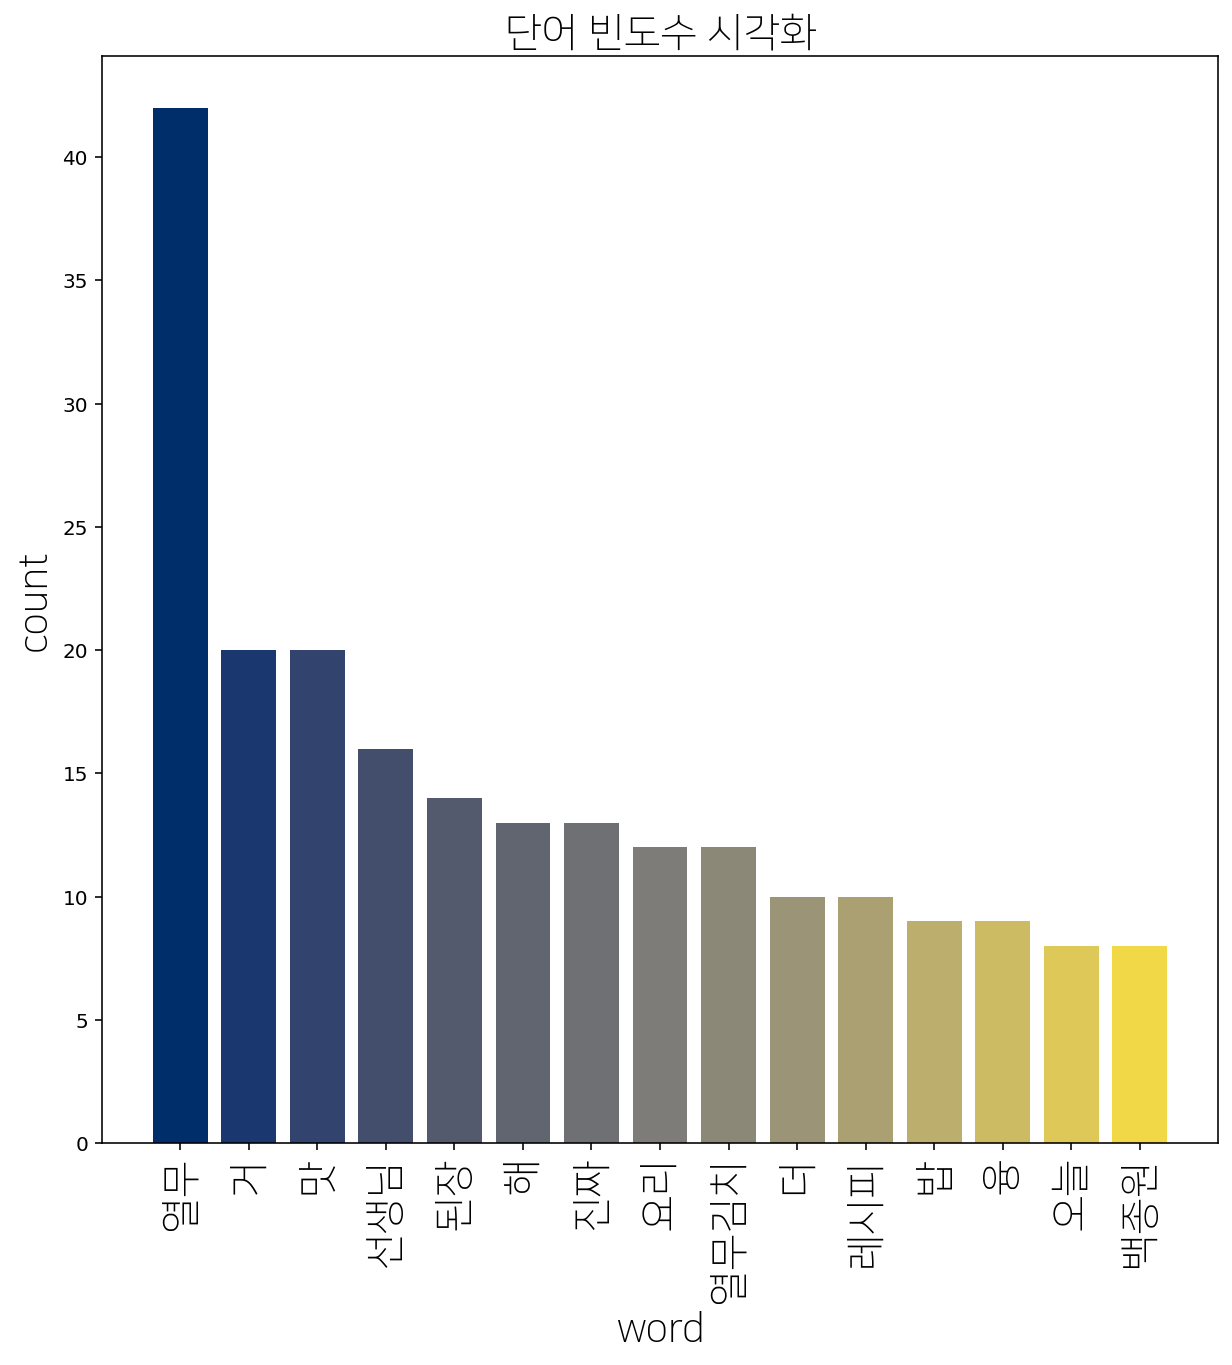

In [26]:

noun_list = []
for i in range(len(comment_result)):
    for j in range(len(comment_result['token'].iloc[i])):
        noun_list.append(comment_result['token'].iloc[i][j])
        
counts = Counter(noun_list)
tags = counts.most_common(15)

#bar chart
test = pd.DataFrame({'word':[],
                    'count':[]})
for i in range(len(tags)):
    word = tags[i][0]
    count = tags[i][1]
    
    insert_data = pd.DataFrame({'word':[word],
                                'count':[count]})
    test = test.append(insert_data)

test.index = range(len(test))

#차트에 컬러넣기
import seaborn as sns
colors = sns.color_palette('cividis',len(test))
#그리고 밑에다가 plt.차트형식(괄호 안에 color=추가)



index = np.arange(len(test))
plt2.bar(index,test['count'].tolist(),color=colors)
plt2.xlabel('word', fontsize=8, fontproperties=fontprop)
plt2.ylabel('count', fontsize=8, fontproperties=fontprop)
plt2.xticks(index, test['word'].tolist(), fontsize=1, fontproperties=fontprop, rotation=90)
plt2.title('단어 빈도수 시각화',  fontsize=12, fontproperties=fontprop)
plt2.rcParams['figure.figsize'] = [10, 5]
fig2 = plt2.figure(1)
fig2.set_size_inches(10, 10) # 사이즈 조정

plt2.show()



### 긍정 부정 분석

In [27]:
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

#### 긍정어 부정어 사전

In [123]:
#-*-coding:utf-8-*-

import json

class KnuSL():

	def data_list(wordname):	
		with open('/content/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
			data = json.load(f)
		result = ['None','None']	
		for i in range(0, len(data)):
			if data[i]['word'] == wordname:
				result.pop()
				result.pop()
				result.append(data[i]['word_root'])
				result.append(data[i]['polarity'])	
		
		r_word = result[0]
		s_word = result[1]
							
		print('어근 : ' + r_word)
		print('극성 : ' + s_word)		
		
		
		return r_word, s_word

if __name__ == "__main__":
	
	ksl = KnuSL
	
	print("\nKNU 한국어 감성사전입니다~ :)")
	print("사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!")
	print("종료하시려면 #을 입력해주세요!!!")
	print("-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정")
	print("\n")	

	while(True):
		wordname = input("word : ")
		wordname = wordname.strip(" ")		
		if wordname != "#":
			print(ksl.data_list(wordname))
			print("\n")	
				

		elif wordname == "#":
			print("\n이용해주셔서 감사합니다~ :)")
			break



KNU 한국어 감성사전입니다~ :)
사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!
종료하시려면 #을 입력해주세요!!!
-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정


word : #

이용해주셔서 감사합니다~ :)


#### 불용어 사전

In [30]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

불용어 사전에 추가하기

In [31]:
recipy_words = ['백쌤', '백종원','보다','요린이','에어프라이어','요식업','겁나','썸네일','존귀','썸넬']
for word in recipy_words:
    stopwords.append(word)

#### 정규 표현식 처리

In [29]:
# 정규 표현식 함수 정의

import re

def apply_regular_expression(text):
    hangul = re.compile(r'[^ ㄱ-ㅣ 가-힣ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result



#### 명사 형태소 추출

In [126]:
# lists 에서 명사형태소 추출
okt=Okt()
corpus = "".join(lists)
nouns = okt.nouns(apply_regular_expression(corpus))

# 카운트 세기
counter = Counter(nouns)
counter.most_common(10)


# 한글자 명사 제거
available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)


[('콩국수', 272),
 ('땅콩', 264),
 ('버터', 244),
 ('선생님', 216),
 ('진짜', 196),
 ('콩나물', 188),
 ('요리', 172),
 ('레시피', 168),
 ('음식', 120),
 ('두부', 100)]

* 한글자 명사 제거
* 두 글자 키워드가 대부분 의미 있는 단어지만, ‘수’, ‘것’, '곳’과 같은 한 글자 키워드는 분석에 딱히 좋은 영향을 미치지 않은 것으로 보임.

BoW 벡터 생성

In [134]:
def text_cleaning(text):
    hangul = re.compile(r'[^ ㄱ-ㅣ 가-힣ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns


vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(lists)
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)


In [ ]:
word_list

In [132]:
#-*-coding:utf-8-*-

import json

class DICC():

	def data_list(wordname):	
		with open('/content/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
			data = json.load(f)
		result = ['None','None']	
		for i in range(0, len(data)):
			if data[i]['word'] == wordname:
				result.pop()
				result.pop()
				result.append(data[i]['word_root'])
				result.append(data[i]['polarity'])	
		
		r_word = result[0]
		s_word = result[1]
		
		return r_word, s_word




In [131]:
a=[]
for i in range(0,len(word_list)):
	a.append(DICC.data_list(word_list[i]))

sum=0
for i in range(0,len(a)):
  if a[i][1]!= 'None':
    sum+=int(a[i][1])
print(sum)

24


#### Ex)

In [39]:
okt = Okt()
nouns = okt.nouns(apply_regular_expression(df2['comment'][0]))
nouns

['대부분',
 '레시피',
 '요리',
 '정도',
 '더',
 '이해',
 '병원',
 '남편',
 '간병',
 '콩',
 '요리',
 '집',
 '가면',
 '꼭',
 '해먹',
 '보고',
 '감사']

##### 말뭉치 생성

In [ ]:
corpus = "".join(df2['comment'].tolist())
corpus


불용어구 삭제

In [ ]:
apply_regular_expression(corpus)

##### 전체 말뭉치에서 명사 형태소 추출

In [ ]:
nouns = okt.nouns(apply_regular_expression(corpus))
print(nouns)

##### 빈도수 세기

In [ ]:
counter = Counter(nouns)

In [ ]:
counter.most_common(10)

* 한글자 명사 제거
* 위 결과에서 보이듯이, 두 글자 키워드가 대부분 의미 있는 단어지만, ‘수’, ‘것’, '곳’과 같은 한 글자 키워드는 분석에 딱히 좋은 영향을 미치지 않은 것으로 보임.



In [ ]:
available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

#### 단어 리스트

In [137]:
print(word_list)

['가게', '가공', '가끔', '가능', '가루', '가면', '가발', '가성', '가스', '가시', '가요', '가장', '가정', '가족', '가짜', '간단', '간병', '간부', '간이', '간장', '갈고', '감동', '감사', '감자', '감자전', '감쪽', '감탄', '감탄사', '갑자기', '강의', '강추', '개발', '개인', '거기', '거래처', '거렸', '거르지', '거리', '거의', '거주', '거짓', '걱정', '건가', '건강', '건더기', '검색', '검정', '게란', '게시판', '겨울', '견과류', '결과', '결코', '경우', '계란', '계란후라이', '계량', '계속', '고고', '고기', '고명', '고민', '고추', '고추기름', '고추장', '고춧가루', '고함', '고향', '곡물', '곤란', '곤욕', '골목', '곱슬', '공개', '공유', '공짜', '과학', '관련', '관리', '광고', '광장시장', '광주', '광팬임돠', '교육', '구글', '구독', '구매', '구이', '구입', '국물', '국본', '국산', '국수', '군대', '군림', '굳이', '굿굿', '굿굿굿', '궁합', '귀리', '그거', '그것', '그게', '그냥', '그닥', '그대로', '그때', '그릇', '그림', '그이', '그쥬', '극락', '글좀', '금방', '금전', '급식', '기계', '기네', '기념', '기대', '기도', '기름', '기본', '기분', '기업', '기한', '기회', '김치', '김치넿', '깜짝', '깝질', '깡통', '깨소금', '깨후', '깻잎', '껍데기', '껍질', '꼬랑지', '꼬리', '꾸벅', '꿀맛', '꿀팁', '꿀팁감', '끽해야', '나니', '나라', '나무', '나왓던건데', '나유', '나이', '나중', '날로', '남아', '남편', '내기', '내내', '내년', '내면', '내일', '냄비', '냄새', '냉

In [136]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
count_list

array([12,  8,  4, ...,  4,  8,  4])

👻👻👻👻👻👻👻👻👻👻👻👻👻👻👻👻

In [ ]:
# 각 단어의 리뷰별 등장 횟수
bow_vect.toarray()

In [ ]:
bow_vect.shape

##### "단어" - "총 등장 횟수" Matching


In [ ]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

#### TF-IDF 변환

* Bag of Words 벡터에 대해서 TF-IDF변환 진행합니다.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [ ]:
print(tf_idf_vect.shape)

* 한 행(row)은 한 리뷰를 의미
* 한 열(column)은 한 단어를 의미

In [ ]:
# 첫 번째 리뷰에서의 단어 중요도(TF-IDF 값) -- 0이 아닌 것만 출력
print(tf_idf_vect[0])

In [ ]:
# 첫 번째 리뷰에서 모든 단어의 중요도 -- 0인 값까지 포함
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())


##### “벡터” - “단어” mapping

In [ ]:
vect.vocabulary_

In [ ]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')


### 감성 분류 - Logistic Regression

#### Label